# First Deep Neural Network - Feed Forward Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hemendrarajawat/World-With-Deep-Learning/blob/master/notebooks/First%20Deep%20Neural%20Network.ipynb)

## What is Deep Neural Network?
When we have more than two layers in the model, it's known as Deep Neural Network Model. 

The two layers are same as we have seen in Simple Sigmoid Neuron Model: 
1. Input Layer 
2. Output Layer.

In case of deep neural network we also have **Hidden Layers**. There can be n hidden layers depending on the complexity of the model. And every hidden consist of m Sigmoid Neuron.

With Simple Sigmoid Neuron, we can't work on non-linearly separable data but with the help of combination of Sigmoid Neuron we can predict any complex function. 

Below are some basic representational of Deep Neural Network:

<br/>
<img src="https://miro.medium.com/max/978/0*0mia7BQKjUAuXeqZ.jpeg" alt="Deep Neural Network 1"  width="400" />

<br/><br/>

<img src="https://i0.wp.com/bdtechtalks.com/wp-content/uploads/2018/02/deep-neural-networks.png" alt="Deep Neural Network 2"  width="400" />

<br/>

Let's use some non-linear dataset and see how we can use the deep neural networks to predict the labels. We will first see the prediction with Sigmoid Neuron and after with Feed Forward Neuron to compare the accuracy. 

## Import Libaries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(0)
my_cmap = LinearSegmentedColormap.from_list('', ['red', 'yellow', 'green'])

## Create Data

In [0]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)

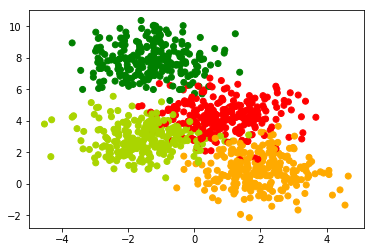

In [3]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

Let's create the non-linear data.

In [0]:
orig_labels = labels
labels = np.mod(labels, 2)

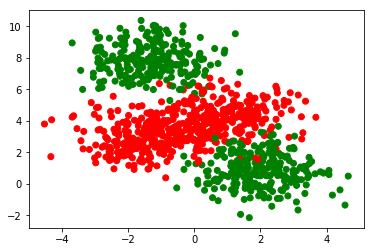

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Train-Test Split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0)

In [7]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(750, 2) (750,)
(250, 2) (250,)


## Sigmoid Neuron Class

In [0]:
class SigmoidNeuron:
  def __init__(self):
    self.w = None
    self.b = None
    
  def sigmoid(self, x):
    return (1.0 / (1.0 + np.exp(-(np.dot(x, self.w.T) + self.b))))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(x)
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(x)
    return (y_pred - y) * y_pred * (1 - y_pred)
      
  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=True):
    if initialize:
      np.random.seed(0)
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = []
      
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dw = 0
      db = 0
      for x,y in zip(X, Y):
        dw += self.grad_w_mse(x, y)
        db += self.grad_b_mse(x, y)
          
      m = X.shape[1]
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m
          
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(mean_squared_error(Y, Y_pred))
          
    if display_loss:
      print('Min Loss:', loss[np.argmin(loss)])
      print('Loss after training:', loss[-1])
      plt.plot(loss)
      plt.title('Loss/Epochs Plot')
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = self.sigmoid(X)
    return np.array(Y_pred)

## Deep Neural Network Class

In [0]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):
    np.random.seed(0)
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      np.random.seed(0)
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = []
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(mean_squared_error(Y_pred, Y))
    
    if display_loss:
      print('Min Loss:', loss[np.argmin(loss)])
      print('Loss after training:', loss[-1])
      plt.plot(loss)
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

## Train & Validate Sigmoid Neuron Model

Train Sigmoid Neuron Model


Min Loss: 0.2645948465226378
Loss after training: 0.26465214412812543


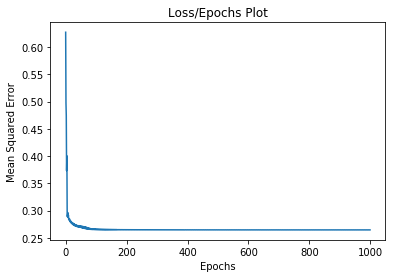

In [10]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.4, display_loss=True)

Validate Sigmoid Neuron Model

In [11]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()

Y_pred_val = sn.predict(X_test)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.72


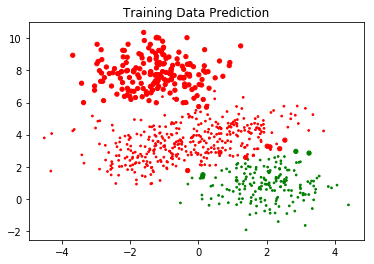

In [12]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.title('Training Data Prediction')
plt.show()

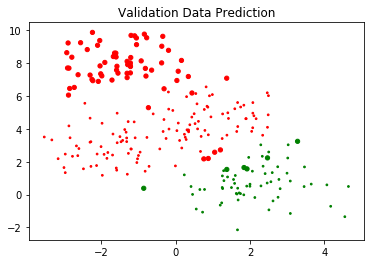

In [13]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_pred_binarised_val, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_val-Y_test)+.2))
plt.title('Validation Data Prediction')
plt.show()

The points that are larger in size are the ones that were predicted wrong. 
The accuracy is pretty low and by looking at the plot we can see that the Sigmoid Neuron was not able to predict with good accuracy. Now let's train the Deep Neural Network Model and see the accuracy.

## Train and Validate Deep Neural Network Model

Train the model


Min Loss: 0.02032056026773391
Loss after training: 0.02032056026773391


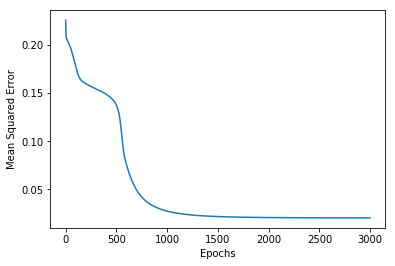

In [16]:
model = FFSNNetwork(X_train.shape[1], [2])
model.fit(X_train, Y_train, epochs=3000, learning_rate=0.001, display_loss=True)

Validate the model

In [17]:
Y_pred_train = model.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()

Y_pred_val = model.predict(X_test)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.97
Validation accuracy 0.94


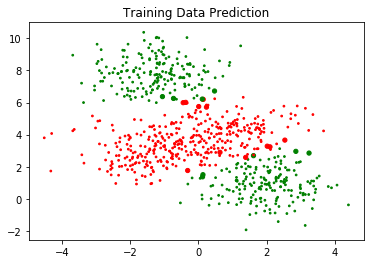

In [19]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.title('Training Data Prediction')
plt.show()

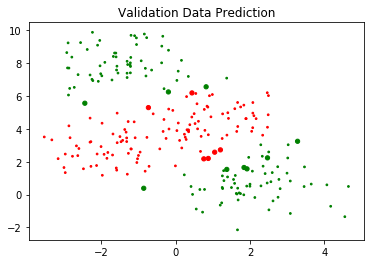

In [18]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_pred_binarised_val, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_val-Y_test)+.2))
plt.title('Validation Data Prediction')
plt.show()

The accuracy for the same data is much higher in Deep Neural Network Model and the wrong predictions are also very less. 

In the next module, we will look in more non-linear data and will purely train the Deep Neural Network model.